In [ ]:
import os 
import time
import cv2
from matplotlib import pyplot as pt
from os.path import join, isfile
import numpy as np
from os import listdir
from google.colab.patches import cv2_imshow


In [ ]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/YOLO.zip

--2022-07-07 18:12:17--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/YOLO.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.144.22
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.144.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231559154 (221M) [application/zip]
Saving to: ‘YOLO.zip.1’

YOLO.zip.1          100%[===================>] 220.83M  11.8MB/s    in 21s     

2022-07-07 18:12:39 (10.5 MB/s) - ‘YOLO.zip.1’ saved [231559154/231559154]



In [ ]:
!unzip YOLO.zip

Archive:  YOLO.zip
replace YOLO/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: YOLO/.DS_Store          
replace __MACOSX/YOLO/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/YOLO/._.DS_Store  
  inflating: YOLO/images/londonxmas2.jpeg  
  inflating: __MACOSX/YOLO/images/._londonxmas2.jpeg  
  inflating: YOLO/images/coffee_view.jpeg  
  inflating: __MACOSX/YOLO/images/._coffee_view.jpeg  
  inflating: YOLO/images/coffee.jpg  
  inflating: __MACOSX/YOLO/images/._coffee.jpg  
  inflating: YOLO/images/iceland_rum.jpeg  
  inflating: __MACOSX/YOLO/images/._iceland_rum.jpeg  
  inflating: YOLO/images/rot.jpg     
  inflating: __MACOSX/YOLO/images/._rot.jpg  
  inflating: YOLO/images/tommys_beers.jpeg  
  inflating: __MACOSX/YOLO/images/._tommys_beers.jpeg  
  inflating: YOLO/images/Volleyball.jpeg  
  inflating: __MACOSX/YOLO/images/._Volleyball.jpeg  
  inflating: YOLO/images/truck.jpg   
  inflating: __MACOSX/YOLO/images/._truck.jpg  
  inflating

In [ ]:
#labels ko kholke ek list mei likh rhe hain
#labels coco.names mei vertically saved hain, hum unhe list mei (horizontally) save krna chahte hain

labels_path="/content/YOLO/yolo/coco.names"
labels=open(labels_path).read().strip().split('\n')
#ab hum randomly len(labels)*3 =240 numbers 0 se 255 ke beech mei select karenge
colors=np.random.randint(0,255,size=(len(labels),3),dtype='uint8')
#ab hum yolo v3 ke already trained model ko relode karenge
net=cv2.dnn.readNetFromDarknet('/content/YOLO/yolo/yolov3.cfg','/content/YOLO/yolo/yolov3.weights')
#now we will set the backend of the model
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)



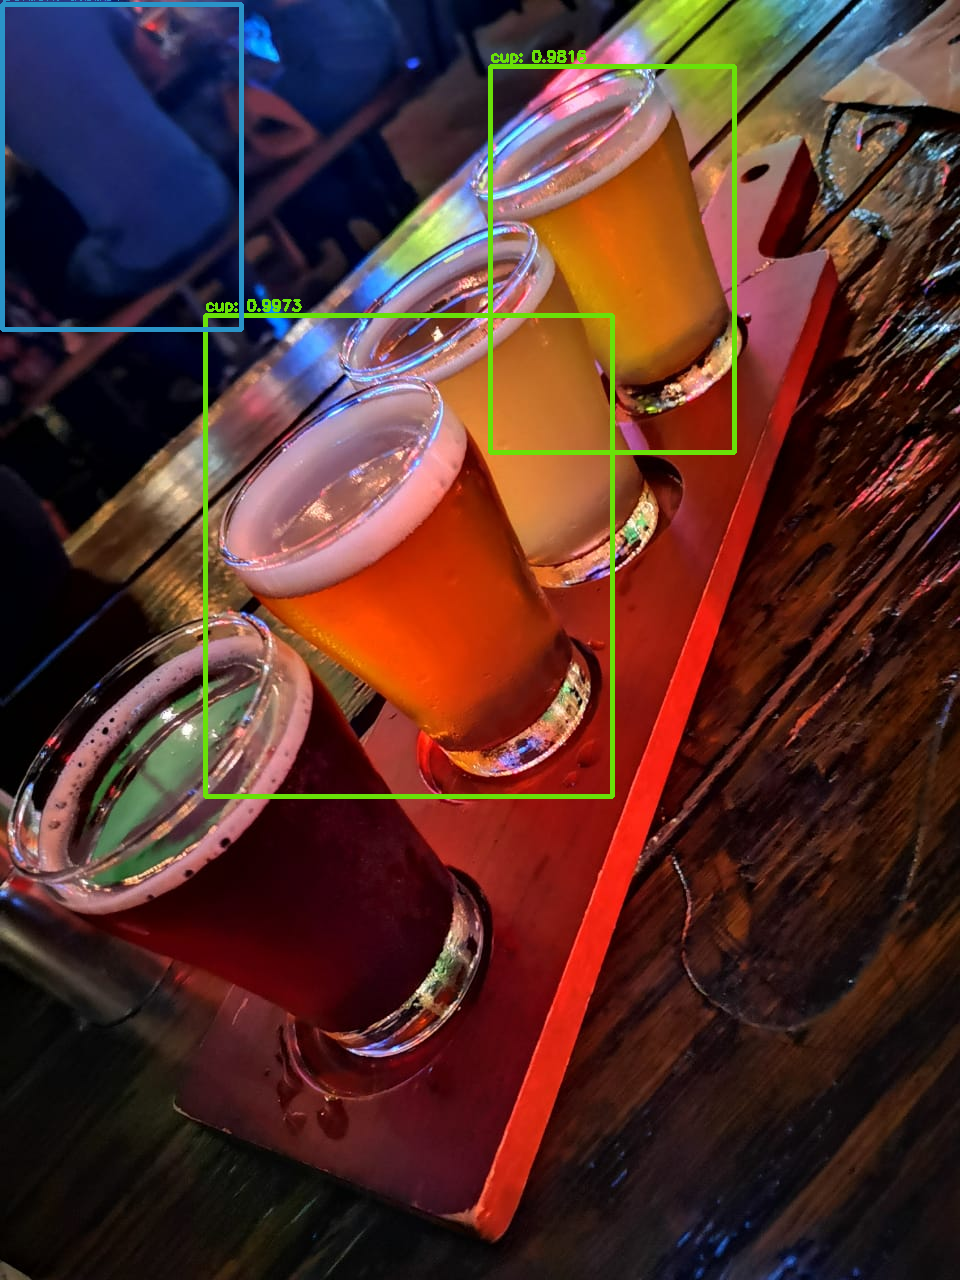

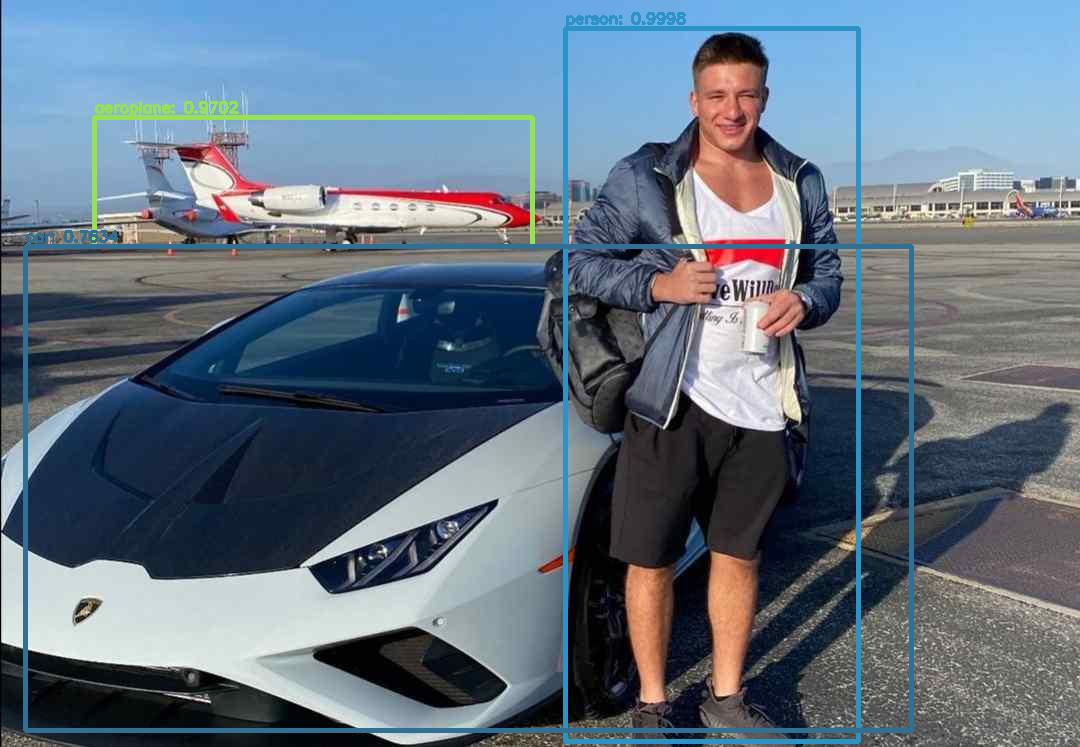

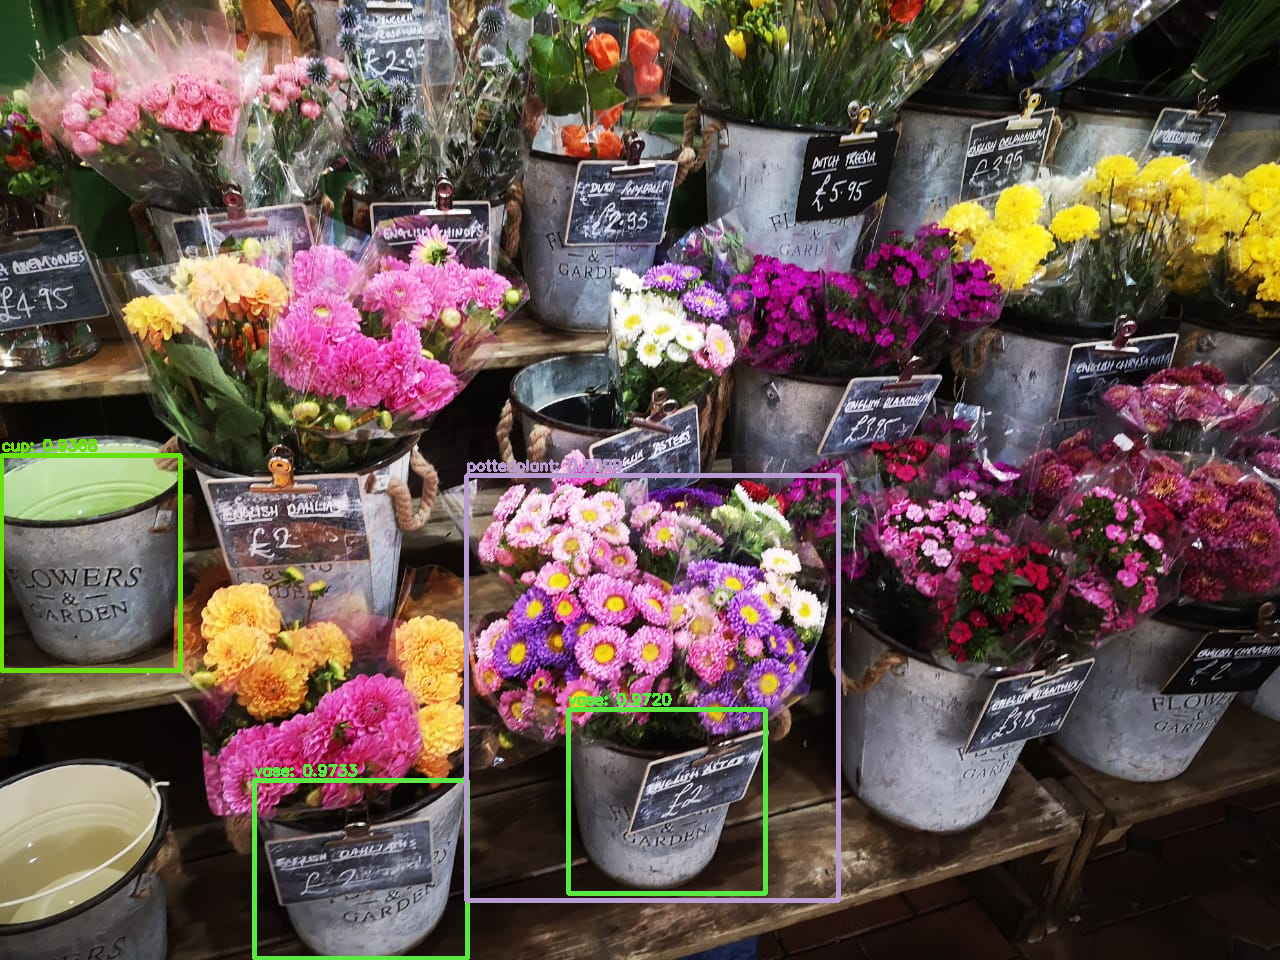

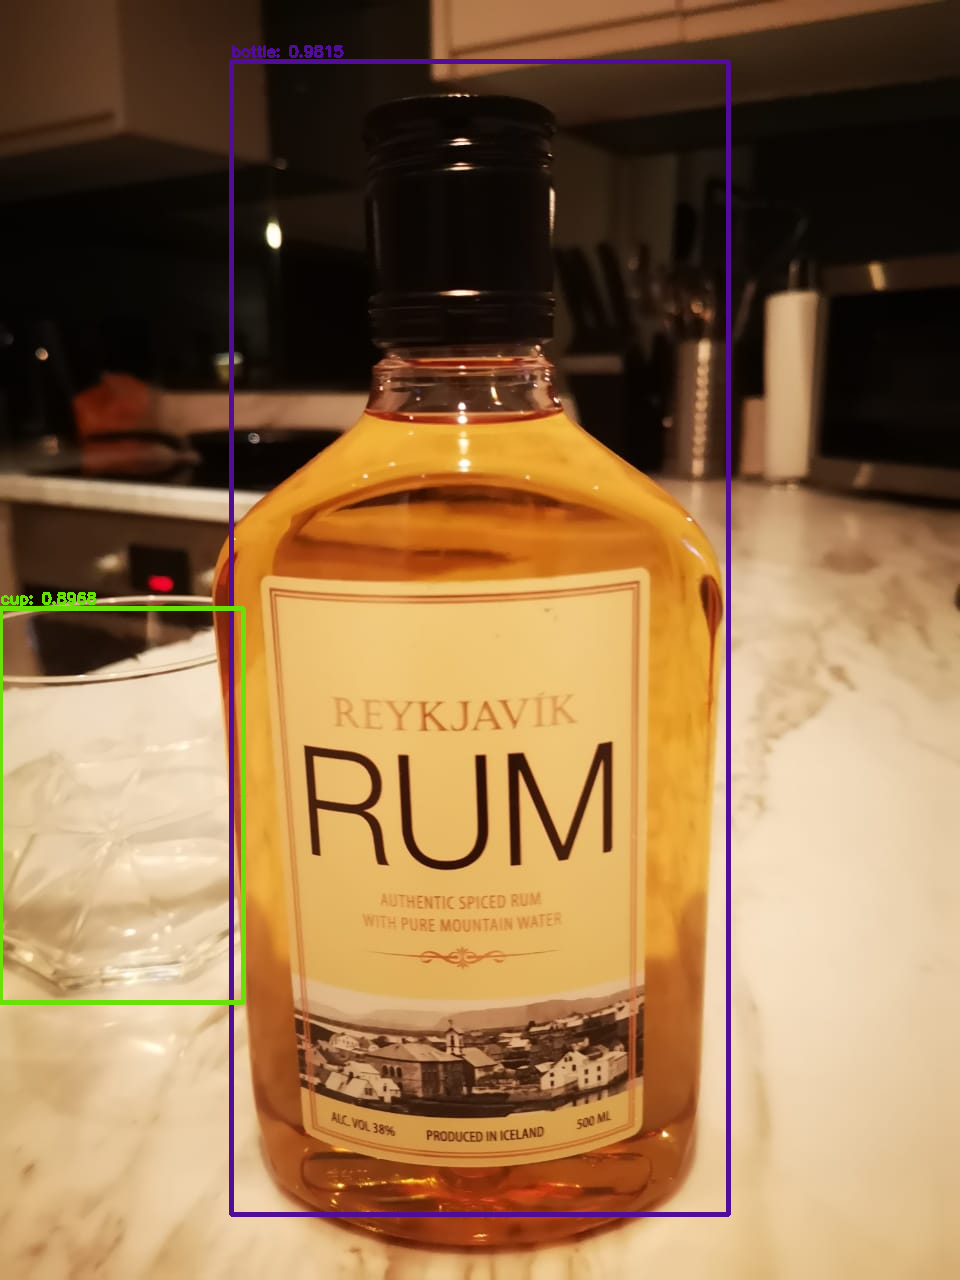

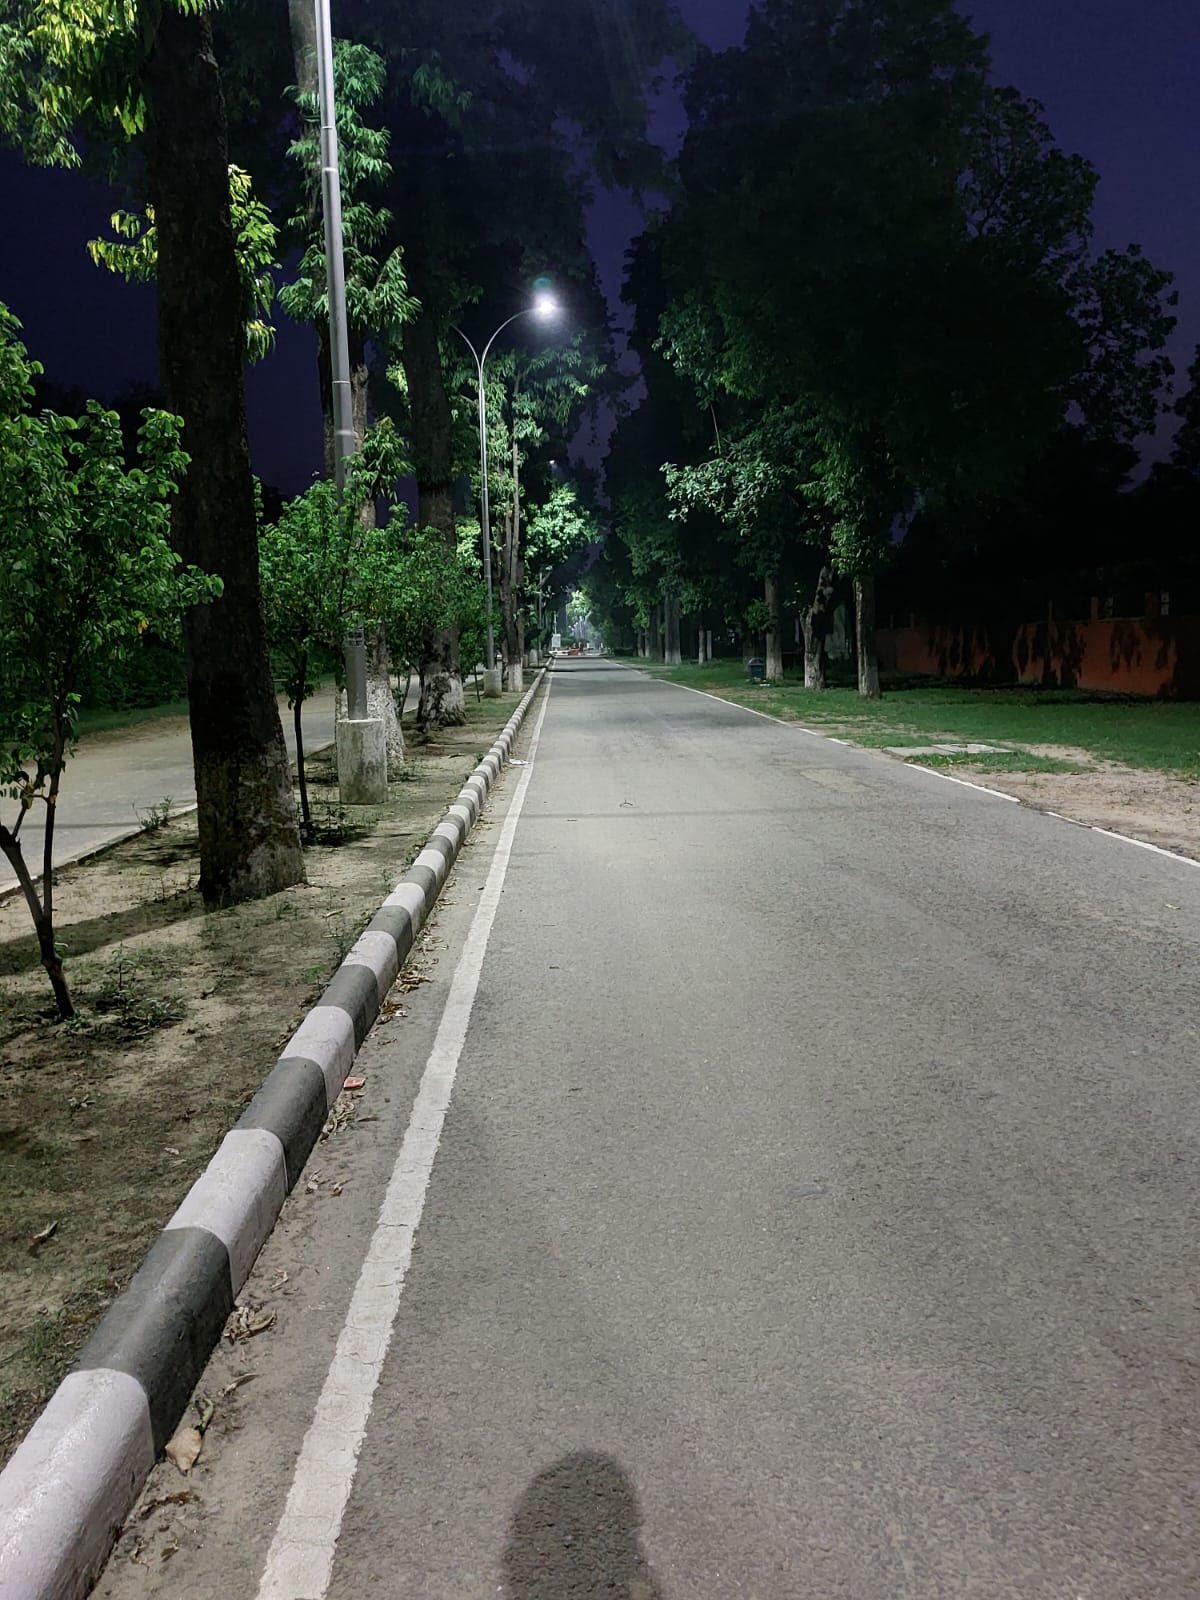

In [ ]:
#ab hum images folder mei jo bhi files hain unke naam ek file_s naam ki list mei store karenge
file_path='/content/YOLO/images/'
file_s=[f for f in listdir(file_path) if isfile(join(file_path,f))]
#ab hum for loop lga ke ek ek karke images ko model mei input denge
for file in file_s:
  image=cv2.imread(file_path+file)
  (H,W)=image.shape[:2]
  # ab images se blob nikalenge aur model mei denge
  # defination of blob -->A Blob, in a sense, is anything that is considered a large object or anything bright in a dark background, in images, 
  # we can generalize it as a group of pixel values that forms a somewhat colony or a large object that is distinguishable from its background. 
  # Using image processing, we can detect such blobs in an image
  blob=cv2.dnn.blobFromImage(image,1/255,(416,416),swapRB=True,crop=False)
  net.setInput(blob)
  # net.getUnconnectedOutLayersNames() hume yolov3 ke output layers ke naame dedeta hain
  # output layers of yolov3 --> yolo82, yolo94 and yolo106
  # yolo has total 106 layers jisme se 53 layers darnet se li jaati hain (jo imagenet pe trained hoti hain) and baaaki 53 detection ke liye 
  # hoti hain
  out_ln=net.getUnconnectedOutLayersNames()
  # Now we will run a forward pass through the network
  out_layers=net.forward(out_ln)
  # Now we will initialize our lists for our detected bounding boxes, confidences, and classes
  confidence_s=[]
  class_ids=[]
  boxe_s=[]
  for output in out_layers:
    for detection in output:
     # scores detection ke 5th ya 5th se aage waale index se isleye liye hain cause classes ke scores output vector(here detection) mei 
     # 4th index ke aage se start hote hain
     # 0,1,2,3 --> x,y,width,height (x,y represent the coordinates of midpoint of bounding box)
     # 4 -->  gives Pc -->probablity of detecting a class
     # 5 and 5 onwards ---> probablity of detecting individual class
     scores=detection[5:]
     #np.argmax gives index having the max value
     ids=np.argmax(scores)
     confidence=max(scores)
     
     if confidence >0.75:
       # We will now scale the bounding box coordinates relative to the image
       box=detection[0:4]*np.array([W,H,W,H])
       (centre_x,centre_y,width,height)=box.astype("int")
       # now we will get the cordinates (i.e x & y) of bottom left corner of image 
       x=(centre_x-width/2)
       y=(centre_y-height/2)
       # ab append karte waqt int mei convert krna bahut zyada zaruri hain warna program nhi chalega(reason nhi pta) & it the same for 
       # converting confidence in float while appending
       boxe_s.append([int(x),int(y),int(width),int(height)])
       class_ids.append(ids)
       confidence_s.append(float(confidence))

  # ab hum multiple bounding box ki problem intersection over union (IOU) se solve krenge
  # Non Maximum Suppression (NMS) is a technique used in numerous computer vision tasks.It is a class of algorithms to select one  
  # entity (e.g., bounding boxes) out of many overlapping entities. IOU is a part of NMS.
  idxs = cv2.dnn.NMSBoxes(boxe_s,confidence_s,0.5,0.3)
  if len(idxs)>0:
    for i in idxs.flatten():
      # now we will get the cordinates (i.e x & y) of bottom left corner of image, since earlier declared x,y (in for loop) are local variables 
      # isliye humne unhe boxe_s list mei dala(jo ki globally declared hain) taaki hum unhe baad mei list mei se nikal ke use kar ske
      (x,y)=boxe_s[i][0],boxe_s[i][1]
      (width,height)=boxe_s[i][2],boxe_s[i][3]

      colo_r=[int(c) for c in colors[class_ids[i]]]
      # rectangle banao
      cv2.rectangle(image,(x,y),(x+width,y+height),colo_r,3)
      # kausi class yolo ne detect kri hain uske hisab se label choose kro
      # give this step some time cause its very crucial and thoghtfull and do remember class is actually a number and label is text( for ex
      # person,car,etc.) For example class 8 belons to the label Truck and class 9 belongs to the label Boat , you can check more classes
      # by opening coco.names folder inside yolo.(Must open!)
      text="{}: {:.4f}".format(labels[class_ids[i]],confidence_s[i])
      #text ko image pe daalo
      cv2.putText(image,text,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,colo_r,2)

  # image ko show kro       
  cv2_imshow(image)    
  

# well it took me around 4 days to understand this code and the architecture of yolov3 and am glad ki finally mujhe yeh pura code samaj mei
# aa gya, i know ki iss kaam ko max 1-2 days lagne chahiye the but like mujhe bahut anxiety ho rhi thi casue kuch samaj nhi aa rha tha
# plus mei net pe dhund rha tha ki koi mujhe yeh pura code samja de but mujhe aise koi video nhi mili, toh in the end yehi option bacha ki har 
# function ko google kiya jaye, jo ki maine kiya.Ab mujhe pta chal gya ki maine kya galtiya kri,toh i promise ki next time se itna time nhi 
# lgega & am really very happy ki finally mujhe yeh code samaj mei aagaya.So just wanna let you know ki keep pushing forward &  you wont 
# regret!
 




   




  

3